---
title: Smart Constructors and ayclic egraphs
---


https://www.philipzucker.com/bottom_up/
I mentioned that it reminded me of aegraphs.
Jamie responded on mastodon


Hashconsing.
You don't want to hash recursively anymore. So we need to override


Top down matching puts each pattern into its head smart constructor
A bottom up style puts each piece into a different smart constructor. Which is a bummer.



https://www.pypy.org/posts/2022/10/toy-optimizer-allocation-removal.html
JIT is straight line which is pretty cool.

JIT guards are like asserts. They have a notion of context that we learn things that are true past them

cleaning up allocations is important. Analsysi to avoid calling new or onlycall new after its settled down
Assume type data objects haven't changed.

https://github.com/tekknolagi/zero-to-aegraphs/tree/trunk


In [ ]:
# aegraph






In [ ]:
#https://www.pypy.org/posts/2022/07/toy-optimizer.html
import pytest
from typing import Optional, Any

class Value:
    pass

class Constant(Value):
    def __init__(self, value: Any):
        self.value = value

    def __repr__(self):
        return f"Constant({self.value})"
    
class Operation(Value):
    def __init__(self, name: str, args: list[Value]):
        self.name = name
        self.args = args

    def __repr__(self):
        return f"Operation({self.name}, {self.args})"

    def arg(self, index: int):
        return self.args[index]

def test_construct_example():
    # first we need something to represent
    # "a" and "b". In our limited view, we don't
    # know where they come from, so we will define
    # them with a pseudo-operation called "getarg"
    # which takes a number n as an argument and
    # returns the n-th input argument. The proper
    # SSA way to do this would be phi-nodes.

    a = Operation("getarg", [Constant(0)])
    b = Operation("getarg", [Constant(1)])
    # var1 = add(b, 17)
    var1 = Operation("add", [b, Constant(17)])
    # var2 = mul(a, var1)
    var2 = Operation("mul", [a, var1])
    # var3 = add(b, 17)
    var3 = Operation("add", [b, Constant(17)])
    # var4 = add(var2, var3)
    var4 = Operation("add", [var2, var3])

    sequence = [a, b, var1, var2, var3, var4]
    # nothing to test really, it shouldn't crash

class Block(list):
    def opbuilder(opname):
        def wraparg(arg):
            if not isinstance(arg, Value):
                arg = Constant(arg)
            return arg
        def build(self, *args):
            # construct an Operation, wrap the
            # arguments in Constants if necessary
            op = Operation(opname,
                [wraparg(arg) for arg in args])
            # add it to self, the basic block
            self.append(op)
            return op
        return build

    # a bunch of operations we support
    add = opbuilder("add")
    mul = opbuilder("mul")
    getarg = opbuilder("getarg")
    dummy = opbuilder("dummy")
    lshift = opbuilder("lshift")

def test_convencience_block_construction():
    bb = Block()
    # a again with getarg, the following line
    # defines the Operation instance and
    # immediately adds it to the basic block bb
    a = bb.getarg(0)
    assert len(bb) == 1
    assert bb[0].name == "getarg"

    # it's a Constant
    assert bb[0].args[0].value == 0

    # b with getarg
    b = bb.getarg(1)
    # var1 = add(b, 17)
    var1 = bb.add(b, 17)
    # var2 = mul(a, var1)
    var2 = bb.mul(a, var1)
    # var3 = add(b, 17)
    var3 = bb.add(b, 17)
    # var4 = add(var2, var3)
    var4 = bb.add(var2, var3)
    assert len(bb) == 6

def bb_to_str(bb: Block, varprefix: str = "var"):
    # the implementation is not too important,
    # look at the test below to see what the
    # result looks like

    def arg_to_str(arg: Value):
        if isinstance(arg, Constant):
            return str(arg.value)
        else:
            # the key must exist, otherwise it's
            # not a valid SSA basic block:
            # the variable must be defined before
            # its first use
            return varnames[arg]

    varnames = {}
    res = []
    for index, op in enumerate(bb):
        # give the operation a name used while
        # printing:
        var = f"{varprefix}{index}"
        varnames[op] = var
        arguments = ", ".join(
            arg_to_str(op.arg(i))
                for i in range(len(op.args))
        )
        strop = f"{var} = {op.name}({arguments})"
        res.append(strop)
    return "\n".join(res)

def test_basicblock_to_str():
    bb = Block()
    var0 = bb.getarg(0)
    var1 = bb.add(5, 4)
    var2 = bb.add(var1, var0)

    assert bb_to_str(bb) == """\
var0 = getarg(0)
var1 = add(5, 4)
var2 = add(var1, var0)"""

    # with a different prefix for the invented
    # variable names:
    assert bb_to_str(bb, "x") == """\
x0 = getarg(0)
x1 = add(5, 4)
x2 = add(x1, x0)"""

    # and our running example:
    bb = Block()
    a = bb.getarg(0)
    b = bb.getarg(1)
    var1 = bb.add(b, 17)
    var2 = bb.mul(a, var1)
    var3 = bb.add(b, 17)
    var4 = bb.add(var2, var3)

    assert bb_to_str(bb, "v") == """\
v0 = getarg(0)
v1 = getarg(1)
v2 = add(v1, 17)
v3 = mul(v0, v2)
v4 = add(v1, 17)
v5 = add(v3, v4)"""
    # Note the re-numbering of the variables! We
    # don't attach names to Operations at all, so
    # the printing will just number them in
    # sequence, can sometimes be a source of
    # confusion.

class Value:
    def find(self):
        raise NotImplementedError("abstract")
    def _set_forwarded(self, value):
        raise NotImplementedError("abstract")


class Operation(Value):
    def __init__(self, name: str, args: list[Value]):
        self.name = name
        self.args = args
        self.forwarded = None

    def __repr__(self):
        return (
            f"Operation({self.name},"
            f"{self.args}, {self.forwarded})"
        )

    def find(self) -> Value:
        # returns the "representative" value of
        # self, in the union-find sense
        op = self
        while isinstance(op, Operation):
            # could do path compression here too
            # but not essential
            next = op.forwarded
            if next is None:
                return op
            op = next
        return op

    def arg(self, index):
        # change to above: return the
        # representative of argument 'index'
        return self.args[index].find()

    def make_equal_to(self, value: Value):
        # this is "union" in the union-find sense,
        # but the direction is important! The
        # representative of the union of Operations
        # must be either a Constant or an operation
        # that we know for sure is not optimized
        # away.

        self.find()._set_forwarded(value)

    def _set_forwarded(self, value: Value):
        self.forwarded = value


class Constant(Value):
    def __init__(self, value: Any):
        self.value = value

    def __repr__(self):
        return f"Constant({self.value})"

    def find(self):
        return self

    def _set_forwarded(self, value: Value):
        # if we found out that an Operation is
        # equal to a constant, it's a compiler bug
        # to find out that it's equal to another
        # constant
        assert isinstance(value, Constant) and \
            value.value == self.value

def test_union_find():
    # construct three operation, and unify them
    # step by step
    bb = Block()
    a1 = bb.dummy(1)
    a2 = bb.dummy(2)
    a3 = bb.dummy(3)

    # at the beginning, every op is its own
    # representative, that means every
    # operation is in a singleton set
    # {a1} {a2} {a3}
    assert a1.find() is a1
    assert a2.find() is a2
    assert a3.find() is a3

    # now we unify a2 and a1, then the sets are
    # {a1, a2} {a3}
    a2.make_equal_to(a1)
    # they both return a1 as the representative
    assert a1.find() is a1
    assert a2.find() is a1
    # a3 is still different
    assert a3.find() is a3

    # now they are all in the same set {a1, a2, a3}
    a3.make_equal_to(a2)
    assert a1.find() is a1
    assert a2.find() is a1
    assert a3.find() is a1

    # now they are still all the same, and we
    # also learned that they are the same as the
    # constant 6
    # the single remaining set then is
    # {6, a1, a2, a3}
    c = Constant(6)
    a2.make_equal_to(c)
    assert a1.find() is c
    assert a2.find() is c
    assert a3.find() is c

    # union with the same constant again is fine
    a2.make_equal_to(c)

def constfold_buggy(bb: Block) -> Block:
    opt_bb = Block()

    for op in bb:
        # basic idea: go over the list and do
        # constant folding of add where possible
        if op.name == "add":
            arg0 = op.args[0]
            arg1 = op.args[1]
            if isinstance(arg0, Constant) and \
                    isinstance(arg1, Constant):
                # can constant-fold! that means we
                # learned a new equality, namely
                # that op is equal to a specific
                # constant
                value = arg0.value + arg1.value
                op.make_equal_to(Constant(value))
                # don't need to have the operation
                # in the optimized basic block
                continue
        # otherwise the operation is not
        # constant-foldable and we put into the
        # output list
        opt_bb.append(op)
    return opt_bb


def test_constfold_simple():
    bb = Block()
    var0 = bb.getarg(0)
    var1 = bb.add(5, 4)
    var2 = bb.add(var1, var0)

    opt_bb = constfold_buggy(bb)
    assert bb_to_str(opt_bb, "optvar") == """\
optvar0 = getarg(0)
optvar1 = add(9, optvar0)"""

@pytest.mark.xfail
def test_constfold_buggy_limitation():
    # this test fails! it shows the problem with
    # the above simple constfold_buggy pass

    bb = Block()
    var0 = bb.getarg(0)
    # this is folded
    var1 = bb.add(5, 4)
    # we want this folded too, but it doesn't work
    var2 = bb.add(var1, 10)
    var3 = bb.add(var2, var0)

    opt_bb = constfold_buggy(bb)
    assert bb_to_str(opt_bb, "optvar") == """\
optvar0 = getarg(0)
optvar1 = add(19, optvar0)"""

In [26]:
table = {}
def hashcons(c):
    c1 = table.get(c)
    if c1 == None:
        table[c] = c 
        return c
    else:
        return c1
# simple hash consing. Not type safe. Has non short circuiting equality.
# still maybe it's good enough


a = hashcons((1,2,3))
b = hashcons((1,2,3))
c = (1,2,3)
assert not c is b
assert a is b

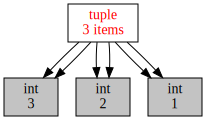

In [30]:
import objgraph
objgraph.show_refs((a,b))

In [38]:
table = {} # hashable -> Intern(hashable)
def hashcons(c):
    c1 = table.get(c)
    if c1 == None:
        c1 = Intern(c)
        table[c] = c1 
        return c1
    else:
        return c1
    
from dataclasses import dataclass
@dataclass(frozen=True, slots=True)
class Intern():
    data: "Any"
    def __hash__(self):
        print("hashing", self)
        return hash(id(self))
    def __eq__(self, other):
        print("==?", self, other)
        return self is other

a = hashcons((1,2,3))
b = hashcons((1,2,3))
a == b
table

x = hashcons(())
print("y")
y = hashcons((x,x))
print("z")
z = hashcons((y,))
z1 = hashcons((y,))
assert z1 is z
w = hashcons((z,z,z))

==? Intern(data=(1, 2, 3)) None
==? Intern(data=(1, 2, 3)) Intern(data=(1, 2, 3))
y
hashing Intern(data=())
hashing Intern(data=())
hashing Intern(data=())
hashing Intern(data=())
z
hashing Intern(data=(Intern(data=()), Intern(data=())))
hashing Intern(data=(Intern(data=()), Intern(data=())))
hashing Intern(data=(Intern(data=()), Intern(data=())))
==? Intern(data=(Intern(data=(Intern(data=()), Intern(data=()))),)) None
hashing Intern(data=(Intern(data=(Intern(data=()), Intern(data=()))),))
hashing Intern(data=(Intern(data=(Intern(data=()), Intern(data=()))),))
hashing Intern(data=(Intern(data=(Intern(data=()), Intern(data=()))),))
hashing Intern(data=(Intern(data=(Intern(data=()), Intern(data=()))),))
hashing Intern(data=(Intern(data=(Intern(data=()), Intern(data=()))),))
hashing Intern(data=(Intern(data=(Intern(data=()), Intern(data=()))),))


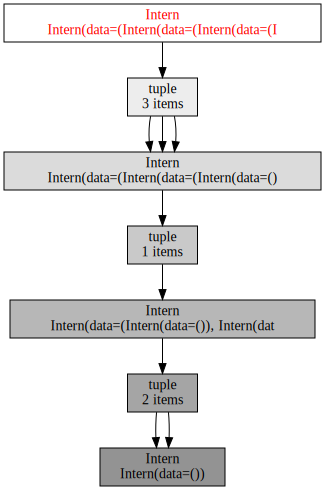

In [39]:
# https://mg.pov.lt/objgraph/ visualizer of object graph
import objgraph
objgraph.show_refs([w], max_depth=10, filter = lambda x: not isinstance(x,type))

Smart constructors

I can have add auto recognize 0, const prop, and associativity commutativity.

We're pretty used to the behavior in the context of representing polynomials. Sympy is rotten with this kind of thing, which can be a problem for some use cases.

This is showing just basic 

In [ ]:
# ok so consider if smart cosnturctor outputs a set/list of interned nodes instead of 

def mul(x,y):
    out = [("mul", x, y)]
    if y == 2:
        out.append(("<<", x, 1))
    return out

# Can I do ematcjing with respect to a previous 

# now matching through finds the indirections
def div(x,y):
    out = [("div", x, y)]
    for x in xs:
        match x:
            case ("mul", a, n):
                for y in ys:
                    match y:
                        case n:
                            out.append(x)
# oh yea. I forgot when you top down ematch it's pretty simple too for concrete problems.


# so where does the union find come in?
# Well, we may discover new versions coming from above.
# Seems marginal though.

# But if I don't, we don't learn anything?




In [5]:
def add(x,y):
    if x == 0:
        return y
    elif y == 0:
        return x
    elif isinstance(x,int) and isinstance(y,int): # const prop
        return x + y
    match y:
        case ("add", ybits):
            ys = ybits
        case _:
            ys = [y]
    match x:
        case ("add", xbits):
            xs = xbits
        case _:
            xs = [x]
    return ("add",sorted(xs + ys))   # hashcons 

add(1,add(2,"x"))



TypeError: '<' not supported between instances of 'str' and 'int'

In [ ]:



options = {}
partials = {}

def hashcons(con):
    match con:
        case ("add", a, b):
            if a == 0:
                return b
            else 
        case ("mul", a, b):
    
    return options, partials













cascades

aegraph
tree of unions

But later things can tap into the frozenset. hmm.
so maybe nested frozensets

smart construcotrs - hashcons frozenset

25-30 minutes. yowzers

Use z3 external egraph. Bottom up, aegraph or grs style.


```python

def add(x,y):
    match x:
        Add()


```